# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [50]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

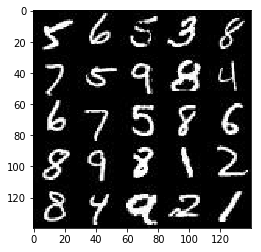

In [51]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

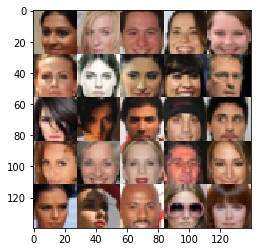

In [52]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [128]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

from tensorflow.contrib.layers import xavier_initializer

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [85]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_ = tf.placeholder(
        tf.float32,
        shape=[
            None,
            image_width,
            image_height,
            image_channels
        ],
        name='real_inputs'
    )
    z_inputs_ = tf.placeholder(
        tf.float32,
        shape=[None, z_dim],
        name='z_inputs'
    )
    learning_rate = tf.placeholder(
        tf.float32,
        name='learning_rate'
    )

    return (inputs_, z_inputs_, learning_rate)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [153]:
import numpy as np

def lrelu(x, alpha=0.1):
    return tf.maximum(alpha * x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        lrelu1 = lrelu(conv1)
        # 14x14x64

        conv2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='same')
        bnconv2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = lrelu(bnconv2)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding='same')
        bnconv3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = lrelu(bnconv3)
        # 4x4x256

        conv4 = tf.layers.conv2d(lrelu3, 512, 5, strides=2, padding='same')
        bnconv4 = tf.layers.batch_normalization(conv4, training=True)
        lrelu4 = lrelu(bnconv4)
        # 2x2x512

        dim = np.product(
            lrelu4.get_shape().as_list()[1:]
        )
        flat = tf.reshape(lrelu4, (-1, dim))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [154]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        h1 = tf.layers.dense(z, 7*7*512)
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = lrelu(h1)

        h2 = tf.layers.conv2d_transpose(h1, 256, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = lrelu(h2)
        # 14x14x256
        
        h3 = tf.layers.conv2d_transpose(h2, 512, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = lrelu(h3)
        # 28x28x512

        h4 = tf.layers.conv2d_transpose(h3, 64, 5, strides=1, padding='same')
        h4 = tf.layers.batch_normalization(h4, training=is_train)
        h4 = lrelu(h3)
        # 28x28x1024
        
        logits = tf.layers.conv2d(h4, out_channel_dim, 5, strides=1, padding='same')

        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [155]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(
        input_z,
        out_channel_dim
    )
    
    d_model_real, d_logits_real = discriminator(
        input_real,
        reuse=False
    )
    
    d_model_fake, d_logits_fake = discriminator(
        g_model,
        reuse=True
    )

    # Label-smoothing
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_model_real) * np.random.uniform(.7, 1.2)
        )
    )

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake) + np.random.uniform(0, .3)
        )
    )

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)
        )
    )

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [156]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    vs = tf.trainable_variables()
    d_vars = [v for v in vs if v.name.startswith('discriminator')]
    g_vars = [v for v in vs if v.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(
            learning_rate,
            beta1=beta1
        ).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate,
            beta1=beta1
        ).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [157]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [158]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    image_width, image_height, image_channels = data_shape[1:]

    input_real, input_z, lr = model_inputs(
        image_width, image_height, image_channels, z_dim
    )

    d_loss, g_loss = model_loss(
        input_real, input_z, image_channels
    )

    d_opt, g_opt = model_opt(
        d_loss, g_loss, learning_rate, 0.5
    )

    steps = 0
    show_every = 100
    print_every = 25
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                batch_images *= 2
                batch_z = np.random.uniform(
                    -1,
                    1,
                    size=(batch_size, z_dim)
                )

                sess.run(d_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z
                })

                sess.run(g_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z
                })

                sess.run(g_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z
                })

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{},".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f},".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    gen_samples = sess.run(
                        generator(
                            input_z,
                            image_channels,
                            False
                        ),
                        feed_dict={
                            input_z: batch_z
                        }
                    )

                    show_generator_output(
                        sess,
                        24,
                        input_z,
                        image_channels,
                        data_image_mode
                    )

        print('Result after training:')
        gen_samples = sess.run(
            generator(
                input_z,
                image_channels,
                False
            ),
            feed_dict={
                input_z: batch_z
            }
        )

        show_generator_output(
            sess,
            24,
            input_z,
            image_channels,
            data_image_mode
        )

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, Discriminator Loss: 1.5097, Generator Loss: 0.4950
Epoch 1/2, Discriminator Loss: 1.7243, Generator Loss: 0.3510
Epoch 1/2, Discriminator Loss: 1.5771, Generator Loss: 0.4911
Epoch 1/2, Discriminator Loss: 1.5720, Generator Loss: 0.4573


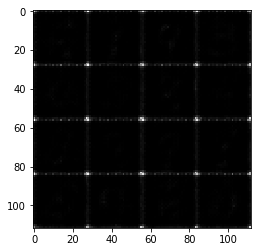

Epoch 1/2, Discriminator Loss: 1.4300, Generator Loss: 0.7049
Epoch 1/2, Discriminator Loss: 1.5062, Generator Loss: 0.4900
Epoch 1/2, Discriminator Loss: 1.5383, Generator Loss: 0.4543
Epoch 1/2, Discriminator Loss: 1.3492, Generator Loss: 0.6713


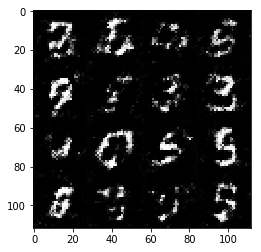

Epoch 1/2, Discriminator Loss: 1.4307, Generator Loss: 0.5493
Epoch 1/2, Discriminator Loss: 1.3368, Generator Loss: 0.8088
Epoch 1/2, Discriminator Loss: 1.4251, Generator Loss: 0.6722
Epoch 1/2, Discriminator Loss: 1.4289, Generator Loss: 0.6301


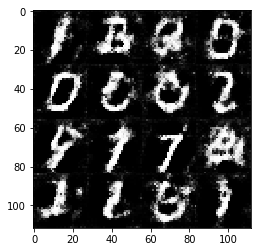

Epoch 1/2, Discriminator Loss: 1.5367, Generator Loss: 0.4839
Epoch 1/2, Discriminator Loss: 1.5780, Generator Loss: 0.4258
Epoch 1/2, Discriminator Loss: 1.6000, Generator Loss: 0.4102
Epoch 1/2, Discriminator Loss: 1.5103, Generator Loss: 0.4901


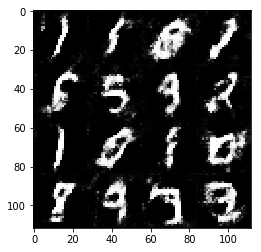

Epoch 1/2, Discriminator Loss: 1.4039, Generator Loss: 0.6426
Epoch 1/2, Discriminator Loss: 1.5551, Generator Loss: 0.4615
Epoch 1/2, Discriminator Loss: 1.4349, Generator Loss: 0.6349
Epoch 1/2, Discriminator Loss: 1.5014, Generator Loss: 0.5128


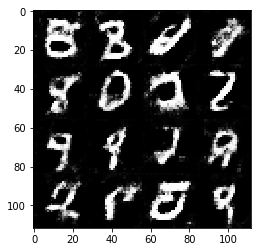

Epoch 1/2, Discriminator Loss: 1.4914, Generator Loss: 0.5484
Epoch 1/2, Discriminator Loss: 1.4270, Generator Loss: 0.5791
Epoch 1/2, Discriminator Loss: 1.4018, Generator Loss: 0.6380
Epoch 1/2, Discriminator Loss: 1.6835, Generator Loss: 0.3630


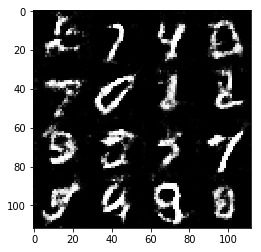

Epoch 1/2, Discriminator Loss: 1.4484, Generator Loss: 0.5627
Epoch 1/2, Discriminator Loss: 1.4213, Generator Loss: 0.6748
Epoch 1/2, Discriminator Loss: 1.5207, Generator Loss: 0.6231
Epoch 1/2, Discriminator Loss: 1.5292, Generator Loss: 0.4711


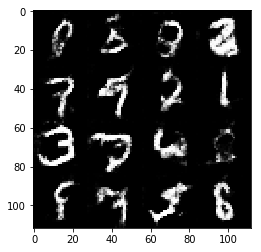

Epoch 1/2, Discriminator Loss: 1.5268, Generator Loss: 0.4735
Epoch 1/2, Discriminator Loss: 1.4818, Generator Loss: 0.5237
Epoch 1/2, Discriminator Loss: 1.4101, Generator Loss: 0.6139
Epoch 1/2, Discriminator Loss: 1.4541, Generator Loss: 0.5940


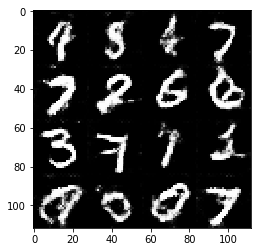

Epoch 1/2, Discriminator Loss: 1.5692, Generator Loss: 0.4378
Epoch 1/2, Discriminator Loss: 1.7667, Generator Loss: 0.3090
Epoch 1/2, Discriminator Loss: 1.5204, Generator Loss: 0.4872
Epoch 1/2, Discriminator Loss: 1.3697, Generator Loss: 0.6759


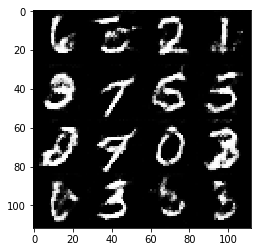

Epoch 1/2, Discriminator Loss: 1.4967, Generator Loss: 0.5419
Epoch 2/2, Discriminator Loss: 1.4451, Generator Loss: 0.6724
Epoch 2/2, Discriminator Loss: 1.4074, Generator Loss: 0.6432
Epoch 2/2, Discriminator Loss: 1.4598, Generator Loss: 0.5752


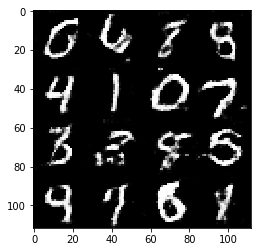

Epoch 2/2, Discriminator Loss: 1.7134, Generator Loss: 0.3380
Epoch 2/2, Discriminator Loss: 1.4484, Generator Loss: 0.5723
Epoch 2/2, Discriminator Loss: 1.4559, Generator Loss: 0.5353
Epoch 2/2, Discriminator Loss: 1.5931, Generator Loss: 0.4189


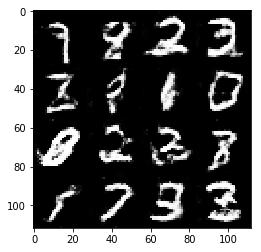

Epoch 2/2, Discriminator Loss: 1.5338, Generator Loss: 0.4836
Epoch 2/2, Discriminator Loss: 1.6620, Generator Loss: 0.3653
Epoch 2/2, Discriminator Loss: 1.4224, Generator Loss: 0.6285
Epoch 2/2, Discriminator Loss: 1.4599, Generator Loss: 0.5553


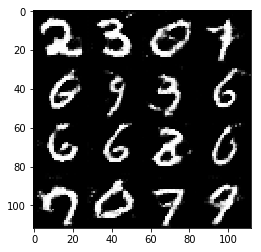

Epoch 2/2, Discriminator Loss: 1.4460, Generator Loss: 0.8375
Epoch 2/2, Discriminator Loss: 1.3295, Generator Loss: 0.8897
Epoch 2/2, Discriminator Loss: 1.4763, Generator Loss: 0.5816
Epoch 2/2, Discriminator Loss: 1.3502, Generator Loss: 0.6961


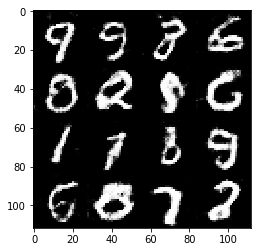

Epoch 2/2, Discriminator Loss: 1.4432, Generator Loss: 0.6468
Epoch 2/2, Discriminator Loss: 1.5806, Generator Loss: 0.4332
Epoch 2/2, Discriminator Loss: 1.4899, Generator Loss: 0.5404
Epoch 2/2, Discriminator Loss: 1.5128, Generator Loss: 0.5660


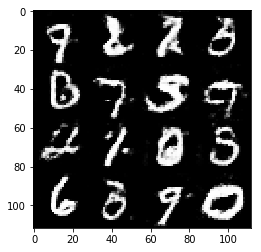

Epoch 2/2, Discriminator Loss: 1.6268, Generator Loss: 0.3884
Epoch 2/2, Discriminator Loss: 1.5559, Generator Loss: 0.4369
Epoch 2/2, Discriminator Loss: 1.4364, Generator Loss: 0.5522
Epoch 2/2, Discriminator Loss: 1.3736, Generator Loss: 0.7822


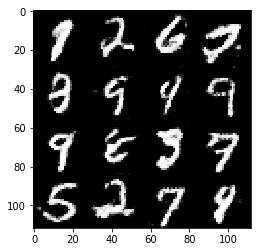

Epoch 2/2, Discriminator Loss: 1.4216, Generator Loss: 0.5573
Epoch 2/2, Discriminator Loss: 1.3742, Generator Loss: 0.6432
Epoch 2/2, Discriminator Loss: 1.8183, Generator Loss: 0.3043
Epoch 2/2, Discriminator Loss: 1.4159, Generator Loss: 0.6010


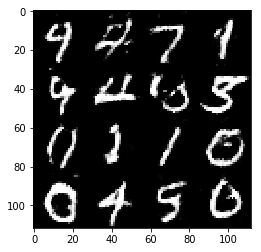

Epoch 2/2, Discriminator Loss: 1.6100, Generator Loss: 0.3931
Epoch 2/2, Discriminator Loss: 1.4687, Generator Loss: 0.5177
Epoch 2/2, Discriminator Loss: 1.3769, Generator Loss: 0.7261
Epoch 2/2, Discriminator Loss: 1.7203, Generator Loss: 0.3328


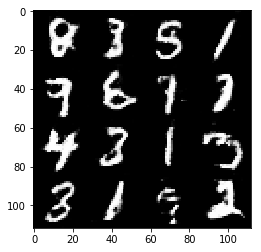

Epoch 2/2, Discriminator Loss: 1.4624, Generator Loss: 0.5186
Epoch 2/2, Discriminator Loss: 1.5183, Generator Loss: 0.4690
Epoch 2/2, Discriminator Loss: 1.3817, Generator Loss: 0.7217
Epoch 2/2, Discriminator Loss: 1.4406, Generator Loss: 0.5561


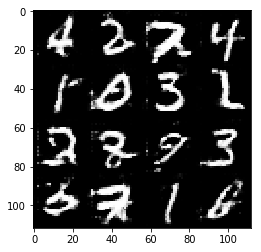

Epoch 2/2, Discriminator Loss: 1.4561, Generator Loss: 0.5384
Epoch 2/2, Discriminator Loss: 1.5282, Generator Loss: 0.4652
Result after training:


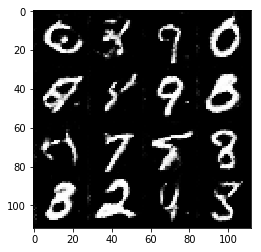

In [162]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

batch_size = 256
z_dim = 128
learning_rate = 0.0001
beta1 = 0.2

batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.1

batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, Discriminator Loss: 1.5297, Generator Loss: 0.4559
Epoch 1/1, Discriminator Loss: 0.8815, Generator Loss: 1.4203
Epoch 1/1, Discriminator Loss: 1.5360, Generator Loss: 0.2933
Epoch 1/1, Discriminator Loss: 1.0343, Generator Loss: 1.1483


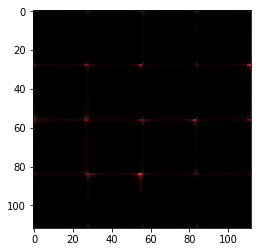

Epoch 1/1, Discriminator Loss: 0.7650, Generator Loss: 3.3125
Epoch 1/1, Discriminator Loss: 1.2679, Generator Loss: 0.6609
Epoch 1/1, Discriminator Loss: 1.5520, Generator Loss: 0.5314
Epoch 1/1, Discriminator Loss: 1.4650, Generator Loss: 0.5441


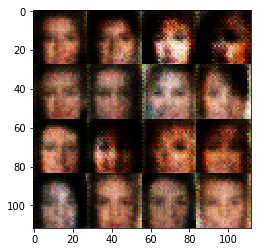

Epoch 1/1, Discriminator Loss: 1.5317, Generator Loss: 0.5903
Epoch 1/1, Discriminator Loss: 1.4399, Generator Loss: 0.6046
Epoch 1/1, Discriminator Loss: 1.4454, Generator Loss: 0.5964
Epoch 1/1, Discriminator Loss: 1.4607, Generator Loss: 0.6214


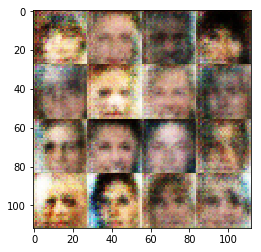

Epoch 1/1, Discriminator Loss: 1.4240, Generator Loss: 0.5919
Epoch 1/1, Discriminator Loss: 1.3373, Generator Loss: 0.6788
Epoch 1/1, Discriminator Loss: 1.3632, Generator Loss: 0.6156
Epoch 1/1, Discriminator Loss: 1.4193, Generator Loss: 0.6184


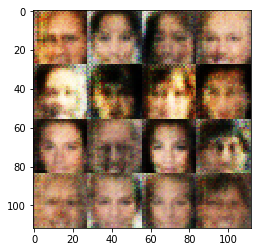

Epoch 1/1, Discriminator Loss: 1.3910, Generator Loss: 0.6329
Epoch 1/1, Discriminator Loss: 1.3862, Generator Loss: 0.6094
Epoch 1/1, Discriminator Loss: 1.3540, Generator Loss: 0.6206
Epoch 1/1, Discriminator Loss: 1.4074, Generator Loss: 0.5954


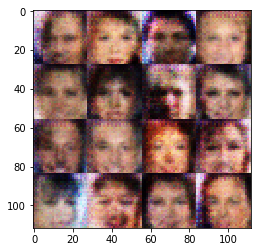

Epoch 1/1, Discriminator Loss: 1.4454, Generator Loss: 0.6183
Epoch 1/1, Discriminator Loss: 1.4513, Generator Loss: 0.5828
Epoch 1/1, Discriminator Loss: 1.4150, Generator Loss: 0.6142
Epoch 1/1, Discriminator Loss: 1.4430, Generator Loss: 0.6014


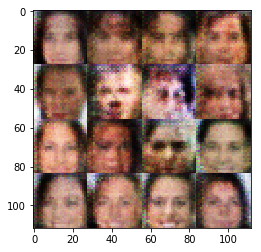

Epoch 1/1, Discriminator Loss: 1.4386, Generator Loss: 0.5900
Epoch 1/1, Discriminator Loss: 1.4147, Generator Loss: 0.6208
Epoch 1/1, Discriminator Loss: 1.4384, Generator Loss: 0.5953
Epoch 1/1, Discriminator Loss: 1.4125, Generator Loss: 0.6174


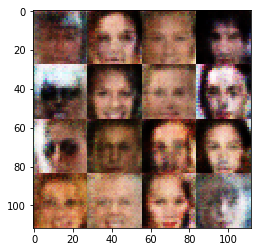

Epoch 1/1, Discriminator Loss: 1.4166, Generator Loss: 0.6098
Epoch 1/1, Discriminator Loss: 1.4002, Generator Loss: 0.6005
Epoch 1/1, Discriminator Loss: 1.3741, Generator Loss: 0.6190
Epoch 1/1, Discriminator Loss: 1.4553, Generator Loss: 0.5928


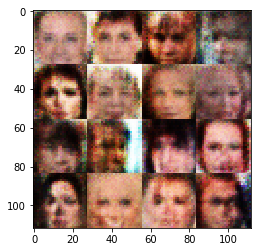

Epoch 1/1, Discriminator Loss: 1.3915, Generator Loss: 0.6307
Epoch 1/1, Discriminator Loss: 1.3991, Generator Loss: 0.6064
Epoch 1/1, Discriminator Loss: 1.4417, Generator Loss: 0.5767
Epoch 1/1, Discriminator Loss: 1.4777, Generator Loss: 0.5776


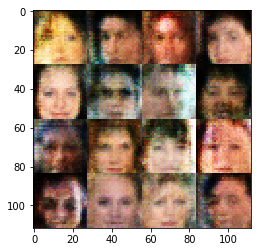

Epoch 1/1, Discriminator Loss: 1.3648, Generator Loss: 0.6660
Epoch 1/1, Discriminator Loss: 1.4261, Generator Loss: 0.5779
Epoch 1/1, Discriminator Loss: 1.3017, Generator Loss: 0.6653
Epoch 1/1, Discriminator Loss: 1.1862, Generator Loss: 0.9026


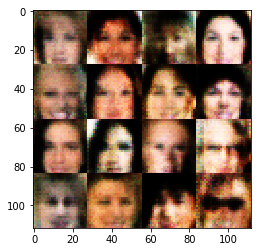

Epoch 1/1, Discriminator Loss: 0.9819, Generator Loss: 0.8655
Epoch 1/1, Discriminator Loss: 1.2825, Generator Loss: 1.2324
Epoch 1/1, Discriminator Loss: 0.9645, Generator Loss: 1.0385
Epoch 1/1, Discriminator Loss: 1.0329, Generator Loss: 1.0010


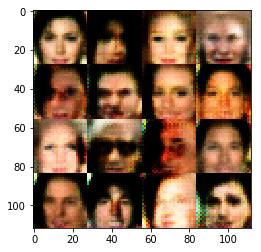

Epoch 1/1, Discriminator Loss: 1.1437, Generator Loss: 0.6144
Epoch 1/1, Discriminator Loss: 1.1615, Generator Loss: 0.9393
Epoch 1/1, Discriminator Loss: 0.7717, Generator Loss: 1.9246
Epoch 1/1, Discriminator Loss: 0.8318, Generator Loss: 2.2998


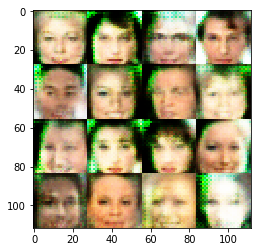

Epoch 1/1, Discriminator Loss: 1.2060, Generator Loss: 0.5031
Epoch 1/1, Discriminator Loss: 1.1754, Generator Loss: 0.6497
Epoch 1/1, Discriminator Loss: 1.2547, Generator Loss: 0.5681
Epoch 1/1, Discriminator Loss: 1.4046, Generator Loss: 0.4298


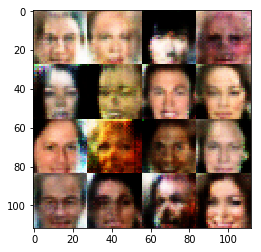

Epoch 1/1, Discriminator Loss: 0.8548, Generator Loss: 1.5600
Epoch 1/1, Discriminator Loss: 0.7853, Generator Loss: 1.7572
Epoch 1/1, Discriminator Loss: 1.4943, Generator Loss: 0.3215
Epoch 1/1, Discriminator Loss: 1.3622, Generator Loss: 0.6606


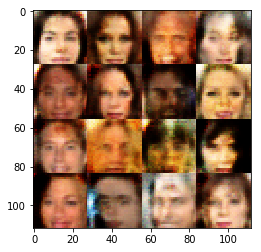

Epoch 1/1, Discriminator Loss: 1.5626, Generator Loss: 0.5389
Epoch 1/1, Discriminator Loss: 1.2445, Generator Loss: 0.5458
Epoch 1/1, Discriminator Loss: 1.4142, Generator Loss: 0.5294
Epoch 1/1, Discriminator Loss: 1.2769, Generator Loss: 0.6336


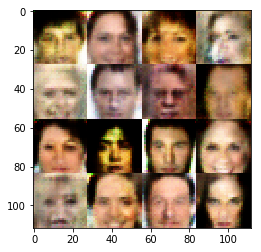

Epoch 1/1, Discriminator Loss: 0.7901, Generator Loss: 1.3494
Epoch 1/1, Discriminator Loss: 1.0692, Generator Loss: 1.7037
Epoch 1/1, Discriminator Loss: 1.3995, Generator Loss: 0.4370
Result after training:


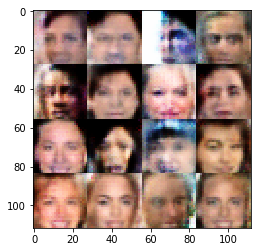

In [164]:
batch_size = 128
z_dim = 64
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.